In [1]:
# Marc Mekhanik, 2607624445
# MATH 578 Lab 1
# This cell will be for basic imports and helper function functions

import numpy as np
import math
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
#set_trace() places a breakpoint into your code

def Mmul (A, x):
    return np.matmul(A,x)
    
def Minv (A,x):
    return np.linalg.solve(A,x)

def force_tridiagonal(A):
    tri_di = A.copy()
    for i in range(len(A)):
        for j in range(len(A)):
            if np.abs(i - j) > 1:
                tri_di[i][j] = 0
            else:
                if i > j:
                    tri_di[i][j] = tri_di[j][i]
                else:
                    pass
    return tri_di

In [2]:
# Sandbox cell, for testing and exploration

#Q1 sandbox
I = np.eye(3,3)
I_diag_signs = np.sign(np.diag(I))
I_diag_signs
np.min(I_diag_signs) == 1

#Q3 sandbox
# Q: does np.triu(A,-1) check that 
A = np.arange(16).reshape(4,4)
np.triu(A,-1)
# yup!

nu =20.

## Question 2

In [5]:
# Question 2
# Write a function that generates random orthogonal matrices
# So generate QR breakdown of random matrix, and return Q
def generate_orthogonal_matrix(n = np.random.randint(1,500)):
    #first, pick random integer for size
    #generate A from Normal distribution
    A = np.random.normal(0,0.5,(n,n))
    #perform QR, my method actually just returns Q anyway
    (Q,R) = Household_QR(A)
    return Q
Q = generate_orthogonal_matrix()
(n,n) = Q.shape
print("Q is orthogonal:", np.allclose(Q.T @ Q, np.eye(n,n)))
# amazing

def generate_symm_matrix(n = np.random.randint(1,500)):
    A = np.random.randn(n,n)
    A_symm = (A + A.T)/2
    return A_symm


Q is orthogonal: True


## Question 1

In [4]:
# Question 1: Implement a function that computes a QR factorization of a given n x n matrix. 
# Use either householder reflections or Givens Rotations. 
# Make sure the diagonal entries of the factor R are nonnegative
# Test on multiple cases


def construct_Q(vectors,vector_sizes,n):
    # this function constructs the Q in our QR decomp.
    Q = np.eye(n,n)
    for k in range(n-2,-1,-1):
        # I can actually just copy the approach to upper traingularize
        # and work on Q in-place.
        # vectors is 2d
        # set_trace()
        to_be_subtracted = 2*Mmul(np.outer(vectors[k,:int(vector_sizes[k])],vectors[k,:int(vector_sizes[k])]),Q[k:n,k:n])
        Q[k:n,k:n] = Q[k:n,k:n] - to_be_subtracted
    # after this iteration, we should have our full Q
    return Q
        

# This upper triangularizes A, and even does so in place, now I need Q.
def Household_QR(B):
    A = B.copy()
    # to sandbox we go
    # This takes a square matrix A
    # and uses householder vectors to reduce it to upper triangular form
    # we're going to store the vectors to construct Q later
    # and we will modify A in-place to save memory
    (n,n) = A.shape
    # this is far too big but I will deal with that later
    vectors = np.zeros(shape=(n,n))
    vector_sizes = np.zeros(n)
    for k in range(0,n):
        # We zero everything below the kth value of the kth column
        x = A[k:n,k]
        #construct standard basis vector
        e = np.zeros(x.size)
        e[0] = 1.0
        # construct reflection vectors
        v = np.sign(x[0])*np.linalg.norm(x)*e + x
        #if v is zero we should skip the iteration
        if np.linalg.norm(v) == 0:
            continue
        # this should be giving me proper signs but isn't
        v = v/np.linalg.norm(v)
        # Append v to vectors
        # this is ugly but works so w/e
        vectors[k,:v.size] = v
        vector_sizes[k] = v.size
        # Apply reflections
        # np.outer computes v * v^T
        A[k:n,k:n] = A[k:n,k:n] - 2*(np.outer(v,v) @ A[k:n,k:n])
    # by the end of this process, A should be upper triangular (will test this now)
    # we will construct Q later
    # I don't need to return A because it is modified in-place
    A_diagonal_signs = np.sign(np.diag(A))
    diag_signs = np.diag(A_diagonal_signs)
    A[:,:] = diag_signs @ A
    Q = construct_Q(vectors,vector_sizes,n)
    return (Q,np.triu(A))

# testing an example matrix
# a1, a2, a3 = [1,2,4],[3,4,6],[2020,4,11]
# A = np.array([a1,a2,a3])
# A_copy = np.array([a1,a2,a3])
# Q = Household_QR(A)

# print("A=", A_copy)
# print("R=", A)
# print("Q=", Q)

# this might work, let's test another
A = np.random.randint(-100,100,(50,50))
B = np.copy(A)
(Q,A) = Household_QR(A)
# test A upper triangular
is_upper_triangular = np.allclose(A,np.triu(A),rtol=1e-05)
# relative tolerance for allclose to return "True" is 1e-05
print ("A is upper triangular now:", is_upper_triangular)
print("Q is orthogonal:", np.allclose(Q.T @ Q, np.eye(50,50)))
# so in my estimation this is... ok

# if all values on diagonal are nonnegative
# the min value of the signs of diagonal entries should be 1.
all_nonnegative = np.min(np.diag(A)) >= 0
print("Diagonal values of A are all nonnegative:", all_nonnegative)
# for n>=50 R isn't reliably upper triangular within relative tolerance 1e-05
# but Q is orthognal within tolerance for n=100

A is upper triangular now: True
Q is orthogonal: True
Diagonal values of A are all nonnegative: True


Question 3: 
Modify QR code to convert a $n \times n $ matrix $A$ into upper Hessenberg Form. Implement also a function that converts $A$ to tridiagonal form. You may wish to force the output matrix to be exactly symmetric and tridiagonal.

Solution: Note that a tridiagonal matrix is both upper and lower Hessenberg. If A symmetric, then we can make it tridiagonal by making it upper hessenberg, and simply setting all super-diagonal entries to match all subdiagonal ones.

In [6]:
# Question 3
# Modify QR code to send a n x n matrix A to upper Hessegberg from
# which I'm pretty sure I can just do by modifying my householder forms to start zeroing one entry down
def Household_Hessenberg(A):
    # This takes a square matrix A
    # and uses householder vectors to reduce it to upper Hessenberg form
    # and we will modify A in-place to save memory
    (n,n) = A.shape
    for k in range(0,n-1):
        # We zero everything below the k+1th value of the kth column
        x = A[k+1:n,k]
        #construct standard basis vector
        e = np.zeros(x.size)
        e[0] = 1.0
        # construct reflection vectors
        v = np.sign(x[0])*np.linalg.norm(x)*e + x
        # this should be giving me proper signs but isn't
        if np.linalg.norm(v) == 0:
            pass
        v = v/np.linalg.norm(v)
        # Apply reflections
        # np.outer computes v * v^T
        A[k+1:n,k:n] = A[k+1:n,k:n] - 2*(np.outer(v,v) @ A[k+1:n,k:n])
    # by the end of this process, A should be upper Hessenberg (will test this now)
    
# this should tridiagonalize A real symmetric matrix A
def tridiagonalize(A):
    # Input a n x n matrix real symmetric A
    Household_Hessenberg(A)
    # force to be tridiagonal and symmetric
    # note that since A symmetric, we should be able to fix values.
    # set_trace()
    tri_di = A.copy()
    for i in range(len(A)):
        for j in range(len(A)):
            if np.abs(i - j) > 1:
                tri_di[i][j] = 0
            else:
                if i > j:
                    tri_di[i][j] = tri_di[j][i]
                else:
                    pass
    return tri_di

    
# B = np.arange(16).reshape(4,4)
# B[0,0] = 2020
# Household_Hessenberg(B)
# print(B)
# print(B.T)
# Household_Hessenberg(B.T)
# print(B)


# now for more general testing
n = np.random.randint(1,10)
A = np.random.randn(n,n)
# # B = np.copy(A)
# B = np.random.randint(-10,10,(4,4))
Household_Hessenberg(A)
is_Hessenberg = np.allclose(np.triu(A,-1),A)
print("A is now upper Hessenberg:", is_Hessenberg)

B = generate_symm_matrix()
C = tridiagonalize(B)
is_tridiagonal  = np.allclose(np.triu(C,-1),C) and np.allclose(np.tril(C,1),C)
print("C is tridiagonal:", is_tridiagonal)



A is now upper Hessenberg: True
C is tridiagonal: True


## Question 4
Write a code that performs the QR algorithm on a given real symmetric tridiagonal
matrix. Produce 3 versions: no shift (i.e., basic QR), the Rayleigh quotient shift, and the
Wilkinson shift. For greater efficiency, you may want to modify your QR factorization
code so that it takes advantage of the tridiagonality (and perhaps symmetry as well).
You may also wish to enforce exact symmetry and tridiagonality at each step of the QR
algorithm.

In [7]:
A = generate_symm_matrix(n=10)
T_D = tridiagonalize(A)
# Since T_D is tridiagonal, it would be more efficient to compute it's QR decomp using Givens rotations
# this would allow for a more efficient computation of Q
# but I am doing this assignment on borrowed time, so I will not do this
def QR_iteration(T_D,nmax,for_plotting=False):
    # input is tridiagonal matrix. 
    # nmax is maximum number of iterations.
    T = T_D.copy()
    (n,n) = T.shape
    if for_plotting:
        eigs = np.zeros((nmax,n))
        subdiags = np.zeros(nmax)
    for i in range(nmax):
        #Compute QR
        (Q,R) = Household_QR(T)
        T = R @ Q
        if i <= (nmax - 2):
            T = force_tridiagonal(T)
        if for_plotting:
            eigs[i][:] = np.diag(T)
            subdiags[i] = T[n-2][n-1]

    # at end of iteration we should be have our T, with eigenvalues of A on diagonal,
    if for_plotting:
        return (sorted(eigs),subdiags)
    return T

T = QR_iteration(T_D,100)
(n,n) = T.shape
print("Max value of bottom row=", np.amax(T[n-1][:n-1]))
is_upper_triangular = np.allclose(T,np.triu(T),rtol=1e-05)
print("T is upper Triangular:", is_upper_triangular)
print("approx. evals of A:", np.diag(T))
#just to peak at the convergence
#that's pretty cool


Max value of bottom row= 0.0
T is upper Triangular: False
approx. evals of A: [-1.98342339 -1.85662053 -1.48591075 -0.92667219 -0.76187157 -0.35145403
 -0.2285795  -0.14387112 -0.09548735  0.03760063]


## Question 4: Rayleigh Quotient Shift

Since in the process, we will eventually get some sort of block matrix with a positive value in the bottom right diagoanal, this is an approximate eigenvalue and we get the the Rayleigh Quotient should be this bottom-most value. I.e.
$$ A = \begin{bmatrix}
A_{n-1} & u \\
0^T & a_{nn}
\end{bmatrix}$$
Where the Rayleigh quotient $\mu(A,a_k) = a_{nn}$. This is a suitable approximation of one of the eigenvalues when, aside from the last diagonal entry, the entries of the bottom row of the matrix are very small in magnitude, which seems to be the case as we can see from the output of our standard QR iteration cell.

In [8]:
def QR_Rayleigh_shift(T_D,nmax,for_plotting=False):
    T = T_D.copy()
    #mu is Rayleigh quotient
    (n,n) = T.shape
    if for_plotting:
        eigs = np.zeros((nmax,n))
        subdiags = np.zeros(nmax)
    for i in range(nmax):
        mu = T[n-1][n-1]
        #Compute QR
        T_shift = T - mu*np.eye(n)
        (Q,R) = Household_QR(T_shift)
        T = R @ Q + mu*np.eye(n)
        if i <= (nmax - 2):
            T = force_tridiagonal(T)
            # set_trace()
        if for_plotting:
            eigs[i][:] = np.diag(T)
            subdiags[i] = T[n-2][n-1]
    if for_plotting:
        return (sorted(eigs),subdiags)
    return T
    
A = generate_symm_matrix(n=4)
T_D = tridiagonalize(A)
T = QR_Rayleigh_shift(T_D,50)
T_noshift = QR_iteration(T_D,100)
(n,n) = T.shape
print("T_{n,n_1}=", T[n-1][n-2])
print("unshifted T_{n,n_1}=", T_noshift[n-1][n-2])
is_upper_triangular = np.allclose(T,np.triu(T),rtol=1e-05)
print("T is upper Triangular:", is_upper_triangular)
print("approx. evals of A (shift):", np.diag(T))
print("approx. evals of A (no shift):", np.diag(T_noshift))

T_{n,n_1}= 0.0
unshifted T_{n,n_1}= 1.6960480231180568e-85
T is upper Triangular: True
approx. evals of A (shift): [-3.71095762 -2.73153994 -1.57744518 -0.94999272]
approx. evals of A (no shift): [-1.59588524 -1.37344378 -0.31614277  0.0435967 ]


## Question 4: Wilkinson Shift
This is designed to exploit symmetry of our target matrix. If we extract the $ 2 \times 2 $ submatrix of A symmetric, which we can represent as 
$$
\begin{bmatrix}
a & b \\
b & c
\end{bmatrix}
$$
This naming convention will help to follow the code below.

In [9]:
def compute_wilkinson_shift(a,b,c):
    delta = (a -c)/2
    mu = c - (np.sign(delta)*b**2)/(abs(delta)+math.sqrt(delta**2+b**2))
    return mu

def QR_wilkinson_shift(T_D,nmax,for_plotting=False):
    T = T_D.copy()
    #mu is wilkinson shift
    (n,n) = T.shape
    if for_plotting:
        eigs = np.zeros((nmax,n))
        subdiags = np.zeros(nmax)
    for i in range(nmax):
        mu = compute_wilkinson_shift(T[n-2][n-2],T[n-2][n-1],T[n-1][n-1])
        #Compute QR
        T_shift = T - mu*np.eye(n)
        (Q,R) = Household_QR(T_shift)
        T = R @ Q + mu*np.eye(n)
        if i <= (nmax - 2):
            T = force_tridiagonal(T)
            # set_trace()
        if for_plotting:
            eigs[i][:] = np.diag(T)
            subdiags[i] = T[n-2][n-1]
    if for_plotting:
        return (sorted(eigs),subdiags)
    return T

A = generate_symm_matrix(n=10)
T_D = tridiagonalize(A)
T = QR_wilkinson_shift(T_D,200)
(n,n) = T.shape
print("T_{n,n_1}=", T[n-1][n-2])
is_upper_triangular = np.allclose(T,np.triu(T),rtol=1e-05)
print("T is upper Triangular:", is_upper_triangular)
print("approx. evals of A (shift):", np.diag(T))

T_{n,n_1}= 0.0
T is upper Triangular: False
approx. evals of A (shift): [-1.85544841 -1.69157952 -1.2066322  -0.59077036 -0.28549859  0.02946647
  0.76759632  1.14938301  1.446723    1.5084034 ]


## Question 5
Generate a symmetric random matrix with a given set of eigenvalues as $A = Q^T \Lambda Q$,
where $Q$ is a random orthogonal matrix, and $\Lambda$ is a diagonal matrix (for example, take
$\Lambda = diag(1,\dots, 10)$. Please set a fixed seed for the random number generator for
reproducibility. Reduce A to a tridiagonal form, and run the QR algorithm on it, by
using the functions you implemented. Pick several of the eigenvalues that represent
variety of possibilities (that is, one small eigenvalue, one mid-sized eigenvalue, etc.),
including the largest eigenvalue, and plot the corresponding errors (in log-scale) against
the iteration number. Moreover, plot the size (in log-scale) of the off-diagonal entries
that are close to the position of the chosen eigenvalues against the iteration number.
Do this for all 3 versions of the QR algorithm. Comment on your results.

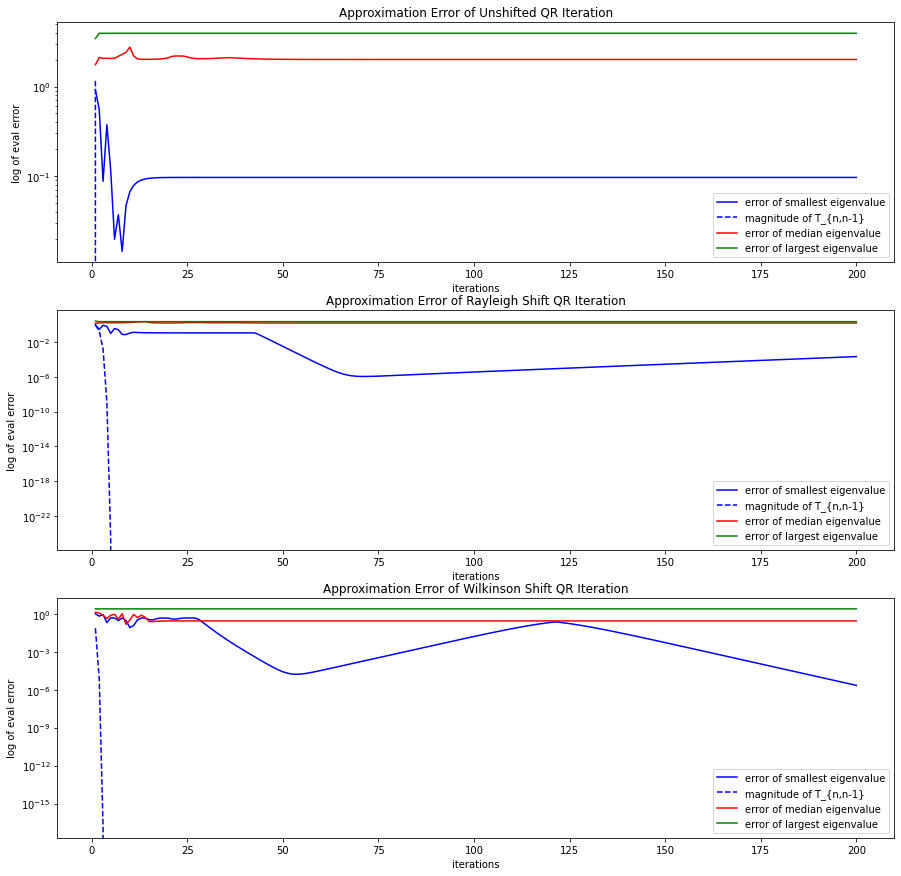

In [72]:
#set seed
np.random.seed(0)
Lambda = np.diag(np.arange(10)+1)
Q = generate_orthogonal_matrix(n=10)
A = Q.T @ Lambda @ Q
T_D = tridiagonalize(A)
(real_eigs,real_evecs) = np.linalg.eig(T_D)

#solve w/ no shift
# I need to track this against evals and errors against iteration number.
# also need size of off_diagonal entries
# I think in total I will do 200 iterations.
(eigs_no_shift,subdiags_no_shift)  = QR_iteration(T_D,200,for_plotting = True)
(eigs_rayleigh_shift,subdiags_rayleigh_shift) = QR_Rayleigh_shift(T_D,200,for_plotting = True)
(eigs_wilkinson_shift,subdiags_wilkinson_shift) = QR_wilkinson_shift(T_D,200,for_plotting = True)

# reminder of dimension
# eigs = np.zeros((nmax,n))
# subdiags = np.zeros(nmax)
fig,(ax1,ax2,ax3) = plt.subplots(3,figsize=(15,15))
num_of_iters = np.arange(200)+1

#Unshifted_QR
error_smallest = np.abs(np.min(real_eigs) - np.min(eigs_no_shift,axis=1))
err_median = np.abs(np.median(real_eigs) - np.median(eigs_no_shift,axis=1))
err_largest = np.abs(np.max(real_eigs) - np.max(eigs_no_shift,axis=1))
ax1.plot(num_of_iters,error_smallest,"b-",label="error of smallest eigenvalue")
ax1.plot(num_of_iters,subdiags_no_shift,"b--",label="magnitude of T_{n,n-1}")
ax1.plot(num_of_iters,err_median,"r-",label="error of median eigenvalue")
ax1.plot(num_of_iters,err_largest,"g-",label="error of largest eigenvalue")

ax1.set_yscale("log")
ax1.set_xlabel("iterations")
ax1.set_ylabel("log of eval error")
ax1.set_title("Approximation Error of Unshifted QR Iteration")
ax1.legend()

#Rayleigh_shift
error_smallest = np.abs(np.min(real_eigs) - np.min(eigs_rayleigh_shift,axis=1))
err_median = np.abs(np.median(real_eigs) - np.median(eigs_rayleigh_shift,axis=1))
err_largest = np.abs(np.max(real_eigs) - np.max(eigs_rayleigh_shift,axis=1))
ax2.plot(num_of_iters,error_smallest,"b-",label="error of smallest eigenvalue")
ax2.plot(num_of_iters,subdiags_rayleigh_shift,"b--",label="magnitude of T_{n,n-1}")
ax2.plot(num_of_iters,err_median,"r-",label="error of median eigenvalue")
ax2.plot(num_of_iters,err_largest,"g-",label="error of largest eigenvalue")

ax2.set_yscale("log")
ax2.set_xlabel("iterations")
ax2.set_ylabel("log of eval error")
ax2.set_title("Approximation Error of Rayleigh Shift QR Iteration")
ax2.legend()

#Wilkinson shift
error_smallest = np.abs(np.min(real_eigs) - np.min(eigs_wilkinson_shift,axis=1))
err_median = np.abs(np.median(real_eigs) - np.median(eigs_wilkinson_shift,axis=1))
err_largest = np.abs(np.max(real_eigs) - np.max(eigs_wilkinson_shift,axis=1))
ax3.plot(num_of_iters,error_smallest,"b-",label="error of smallest eigenvalue")
ax3.plot(num_of_iters,subdiags_wilkinson_shift,"b--",label="magnitude of T_{n,n-1}")
ax3.plot(num_of_iters,err_median,"r-",label="error of median eigenvalue")
ax3.plot(num_of_iters,err_largest,"g-",label="error of largest eigenvalue")

ax3.set_yscale("log")
ax3.set_xlabel("iterations")
ax3.set_ylabel("log of eval error")
ax3.set_title("Approximation Error of Wilkinson Shift QR Iteration")
ax3.legend()

In the shift methods, the magnitude of $T_{n,n-1}$ drops much faster than in the unshifted method, as is to be expected. It is curious that I seem to have better convergence for the smaller eigenvalues, when we should expect better performance for the larger ones. It is also very odd that both shift methods see error for the smallest eigenvalue increase before dropping off again. This is likely due to an error in my implementation, and had I more time I would go back and fix this.

Otherwise, we see that the shift methods outperform the unshifted method. Typically we would expect Wilkinson shift to be superior, but in this case it seems to be Rayleigh Quotient iteration that seems to give the smallest error. This is again likely due to implementation issues.